In [1]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import scipy
import tensorflow as tf
from sopt.examples.utils import PtychographySimulation
from sopt.examples.tensorflow.far_field_ptychography.tfPtycho import AdamPhaseRetriever
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from tensorflow.python.framework import graph_util
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

W1130 00:22:03.096568 140436005877568 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/graph_utils_custom.py:14: The name tf.NodeDef is deprecated. Please use tf.compat.v1.NodeDef instead.

W1130 00:22:03.098520 140436005877568 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/graph_utils_custom.py:29: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



In [2]:
%load_ext autoreload
%autoreload 2

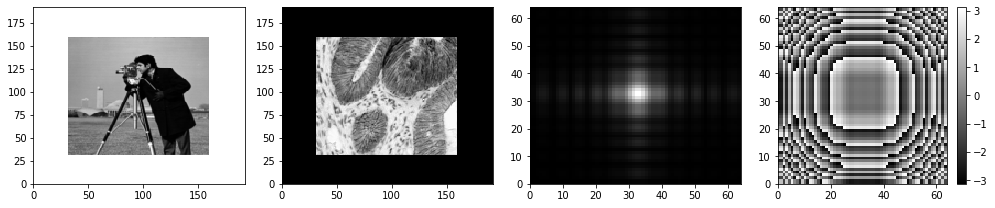

In [3]:
obj_padding_npix = 32
ptsim = PtychographySimulation(obj_npix=128, obj_padding_npix=obj_padding_npix,
                               positions_step_npix=6, probe_n_photons=1e4)

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax3)
plt.tight_layout()
plt.show()

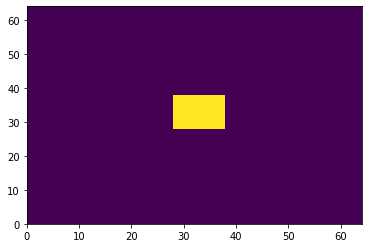

In [4]:
probe_guess = np.zeros_like(ptsim._probe_true)
probe_guess[28:38, 28:38] = 1
probe_guess = probe_guess * np.sqrt(ptsim._probe_n_photons/np.sum(np.abs(probe_guess)**2))
plt.pcolormesh(np.abs(probe_guess))
plt.show()

## Adam - reconstructing the probe and object
Gridsearch to find the best hyperparameters

In [5]:
def runAdam(learning_rate_obj, learning_rate_probe):
    pr_adam = AdamPhaseRetriever(ptsim=ptsim, 
                                 probe_recons=True,
                                 probe_guess_cmplx_2d=probe_guess, 
                                 validation_ndiffs=50,
                                 poisson_loss=True)
    pr_adam.setOptimizingParams(learning_rate_obj=learning_rate_obj,
                                learning_rate_probe=learning_rate_probe)
    pr_adam.initSession()
    pr_adam.run(debug_output_epoch_frequency=100, probe_fixed_epochs=20, improvement_threshold=1e-4, max_iters=500)
    return pr_adam.data.copy()

In [6]:
grid_probe = np.logspace(1, -2, 4)
grid_obj = np.logspace(0, -3, 4)
grid_data = {}
for lp in grid_probe:
    for lo in grid_obj:
        print(lp, lo)
        run_data = runAdam(lo, lp)
        grid_data[(lp, lo)] = run_data.copy()
        print('Final', run_data.tail(n=1))

W1130 00:22:07.073095 140436005877568 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/examples/tensorflow/far_field_ptychography/tfPtycho.py:89: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



10.0 1.0


W1130 00:22:07.275090 140436005877568 deprecation.py:323] From /raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1130 00:22:07.283618 140436005877568 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/examples/tensorflow/far_field_ptychography/tfPtycho.py:204: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1130 00:22:07.288470 140436005877568 deprecation.py:323] From /raid/home/skandel/code/sopt/sopt/examples/tensorflow/far_field_ptychography/tfPtycho.py:116: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` 


Final          loss  epoch  obj_error  probe_error  validation_loss  patience
50  8349867.0   50.0   0.927626          NaN         937054.0      50.0
10.0 0.1



Final          loss  epoch  obj_error  probe_error  validation_loss  patience
50  9059621.0   50.0   0.747377          NaN       1073885.25      50.0
10.0 0.01



Final          loss  epoch  obj_error  probe_error  validation_loss  patience
50  9486595.0   50.0   0.835254          NaN       1060858.75      50.0
10.0 0.001



Final          loss  epoch  obj_error  probe_error  validation_loss  patience
50  7389848.0   50.0   0.915705          NaN         952273.0      50.0
1.0 1.0


100  5547326 0.4554832    133.5 691486.2 681723.1

Final           loss  epoch  obj_error  probe_error  validation_loss  patience
134  5781225.5  134.0   0.488818          NaN        720976.25     133.5
1.0 0.1


100  5462244 0.3388456      150 630750.8 631228.1
200  5409796 0.2131825      204 621845.8 621148.8

Final           loss  epoch  obj_error  probe_error  validation_loss  patience
204  5411483.5  204.0   0.234416          NaN      622152.0625     204.0
1.0 0.01


100  5554013 0.5009065      150 584663.2 584945.1
200  5473938 0.3197755    292.5 572259.1 572307.2

Final           loss  epoch  obj_error  probe_error  validation_loss  patience
293  5462844.0  293.0   0.245789          NaN         569741.0     292.5
1.0 0.001


100  6261302 0.8669434      150 700025.3 700357.2
200  5976351 0.8009681      300 672052.3 672296.1
300  5784631 0.7348208      450   652853 653014.1
400  5654971 0.6722489      600   639157 639271.6

Final           loss  epoch  obj_error  probe_error  validation_loss  patience
499  5570771.5  499.0   0.616302          NaN        629818.75     748.5
0.1 1.0


100  5437006 0.5004605      150 681526.8 681917.8
200  5360844 0.1594628    277.5   666683 666719.2

Final           loss  epoch  obj_error  probe_error  validation_loss  patience
278  5360233.0  278.0   0.139715          NaN        666503.75     277.5
0.1 0.1


100  5540406 0.566767      150 625472.4 625581.1
200  5452914 0.2568095      300 605892.2 606005.1
300  5424720 0.1392481    361.5 600516.2 600487.1

Final           loss  epoch  obj_error  probe_error  validation_loss  patience
362  5424624.0  362.0   0.138091          NaN         600533.0     361.5
0.1 0.01


100  5605074 0.6114692      150   627777   627897
200  5543640 0.5173323      300 619033.5 619099.4
300  5508706 0.4359545      450 612441.5 612523.7
400  5456556 0.3013533      600 602169.1 602287.6

Final           loss  epoch  obj_error  probe_error  validation_loss  patience
499  5433609.5  499.0   0.202757          NaN      597681.5625     720.0
0.1 0.001


100  6324406 0.8672268      150 715964.8 716356.5
200  6037818 0.8039881      300 682571.6 682858.1
300  5829028 0.7355548      450 659091.3 659270.2
400  5698350 0.6712871      600   645258 645377.5

Final           loss  epoch  obj_error  probe_error  validation_loss  patience
499  5614581.5  499.0   0.614328          NaN        635906.75     748.5
0.01 1.0



Final          loss  epoch  obj_error  probe_error  validation_loss  patience
50  5636130.5   50.0   0.878593          NaN        1824165.0      50.0
0.01 0.1



Final          loss  epoch  obj_error  probe_error  validation_loss  patience
50  5695770.0   50.0   0.713228          NaN      743682.3125      50.0
0.01 0.01


100  5672180 0.6870825      138 676469.4 676520.2
200  5588150 0.6316443      300 662216.2   662330
300  5552956 0.6013475    442.5 653917.2   653981
400  5531912 0.5772786    442.5 649597.4 649635.2
Final           loss  epoch  obj_error  probe_error  validation_loss  patience
443  5525721.5  443.0   0.568297          NaN      647535.1875     442.5
0.01 0.001


100  6427744 0.8726995      150 744479.1 744932.8
200  6112984 0.815932      300 708104.8 708383.3
300  5923151 0.7635417      450 686601.6 686767.6
400  5797579 0.7166437      600   673103 673213.1
Final           loss  epoch  obj_error  probe_error  validation_loss  patience
499  5714202.5  499.0   0.677048          NaN       664035.125     748.5


In [8]:
pr_adam = AdamPhaseRetriever(ptsim=ptsim, 
                             probe_recons=True,
                             probe_guess_cmplx_2d=probe_guess, validation_ndiffs=50)
pr_adam.setOptimizingParams(learning_rate_obj=1.0,
                            learning_rate_probe=0.1)
pr_adam.initSession()
pr_adam.run(debug_output_epoch_frequency=100, probe_fixed_epochs=20, improvement_threshold=1e-4)
print(pr_adam.data.tail(n=2))

100 87292.84 0.2654795      150 10738.94 10751.84
200 85413.86 0.1587904    289.5 10484.01 10473.15
300 85541.56 0.1585436    355.5 10471.07 10453.12
             loss  epoch  obj_error  probe_error  validation_loss  patience
355  85593.546875  355.0   0.158730          NaN     10463.644531     355.5
356  85586.718750  356.0   0.158498          NaN     10472.525391     355.5


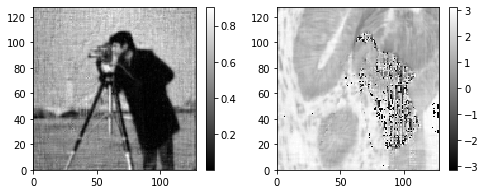

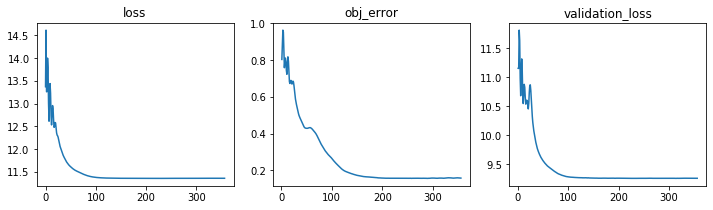

In [9]:
pr_adam.genPlotsRecons()
pr_adam.genPlotMetrics()

In [10]:
with pr_adam.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_adam = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_adam = flops_adam.total_float_ops
    print(flops_adam)

graph_def = pr_adam.graph.as_graph_def()
# To calculate the flops required for one adam step,
# I am removing the nodes required for the validation step.
nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_adam.graph, nodes_validation)
print(flops_validation)

total_flops = (flops_adam - flops_validation) * pr_adam.data.index[-1]
print(f'total flops {total_flops:4.3g}')

W1130 00:24:45.639888 140436005877568 deprecation.py:323] From /raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/tensorflow/python/profiler/internal/flops_registry.py:142: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


848546469
22777709
total flops 2.94e+11


## Adam batch size 100

In [11]:
def runAdamBatched(learning_rate_obj, learning_rate_probe):
    pr_adam = AdamPhaseRetriever(ptsim=ptsim, 
                                 batch_size=100,
                                 validation_ndiffs=50,
                                 probe_recons=True,
                                 probe_guess_cmplx_2d=probe_guess)
    pr_adam.setOptimizingParams(learning_rate_obj=learning_rate_obj,
                                learning_rate_probe=learning_rate_probe)
    pr_adam.initSession()
    pr_adam.run(debug_output_epoch_frequency=100, probe_fixed_epochs=20, improvement_threshold=1e-4)
    return pr_adam.data.copy()

In [12]:
grid_probe = np.logspace(1, -1, 3)
grid_obj = np.logspace(-2, 0, 3)
grid_data = {}
for lp in grid_probe:
    for lo in grid_obj:
        print(lp, lo)
        run_data = runAdamBatched(lo, lp)
        grid_data[(lp, lo)] = run_data.copy()
        print('Final', run_data.tail(n=1))

10.0 0.01


100 25189.68 0.397087    148.5 17598.84 17114.73
200 22422.29 0.2812987      300 13099.74 13132.52
300 24326.57 0.2547504    340.5 14381.83 13022.62
Final               loss  epoch  obj_error  probe_error  validation_loss  patience
1364  26396.916016  341.0   0.251619          NaN       14766.1875     340.5
10.0 0.1


100 28425.89 0.8846733    145.5 16877.29 16356.51
200 27276.19 0.7862537    265.5 14877.87 14430.39
Final               loss  epoch  obj_error  probe_error  validation_loss  patience
1064  29003.271484  266.0   0.702586          NaN     15478.052734     265.5
10.0 1.0


100  33819.8 0.8880958    142.5 21440.97  21179.3
200 35081.51 0.9046402      279 21039.12 20373.55
Final               loss  epoch  obj_error  probe_error  validation_loss  patience
1116  41921.644531  279.0   0.909014          NaN     21021.472656     279.0
1.0 0.01


100 21403.81 0.269977      144 10843.01 10754.29
200 20757.78 0.1900723    202.5 10782.95 10722.22
Final              loss  epoch  obj_error  probe_error  validation_loss  patience
812  19858.058594  203.0   0.188985          NaN     10891.125977     202.5
1.0 0.1


Final              loss  epoch  obj_error  probe_error  validation_loss  patience
248  21067.316406   62.0    0.17361          NaN     10978.469727      61.5
1.0 1.0


Final          loss  epoch  obj_error  probe_error  validation_loss  patience
336  28875.75   84.0   0.397934          NaN     16261.607422      84.0
0.1 0.01


100 20122.78 0.2669755      150 9697.121 9703.396
200 19906.74 0.1823614    289.5 9609.972 9599.795
300  20431.1 0.1596419      423 9597.556 9583.064
400 19411.78 0.1554101    538.5  9595.99 9577.622
500 20293.11 0.1553001    688.5 9591.428  9576.09
600 19413.45 0.1552875    688.5 9584.127  9576.09
Final               loss  epoch  obj_error  probe_error  validation_loss  patience
2756  19369.199219  689.0   0.155351          NaN      9578.805664     688.5
0.1 0.1


100 20214.56 0.1693497      135 10306.34 10284.65
Final              loss  epoch  obj_error  probe_error  validation_loss  patience
624  19104.169922  156.0   0.171348          NaN     10358.261719     156.0
0.1 1.0


Final              loss  epoch  obj_error  probe_error  validation_loss  patience
320  23237.847656   80.0     0.3297          NaN     12825.916016      79.5


In [21]:
pr_adam = AdamPhaseRetriever(ptsim=ptsim, 
                             probe_recons=True,
                             probe_guess_cmplx_2d=probe_guess,
                             batch_size=100,
                             validation_ndiffs=50)
pr_adam.setOptimizingParams(learning_rate_obj=0.1,
                            learning_rate_probe=0.1)
pr_adam.initSession()
pr_adam.run(debug_output_epoch_frequency=100, probe_fixed_epochs=20, improvement_threshold=1e-4)
print(pr_adam.data.tail(n=2))

100 19908.35 0.1710018      114 10949.81 10940.83
             loss  epoch  obj_error  probe_error  validation_loss  patience
611  20665.179688  152.0        NaN          NaN              NaN       NaN
612  19978.214844  153.0   0.174596          NaN     10951.673828     153.0


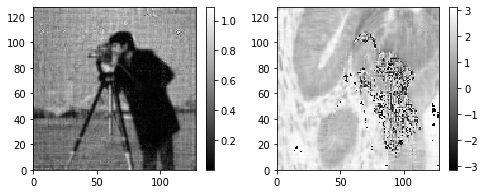

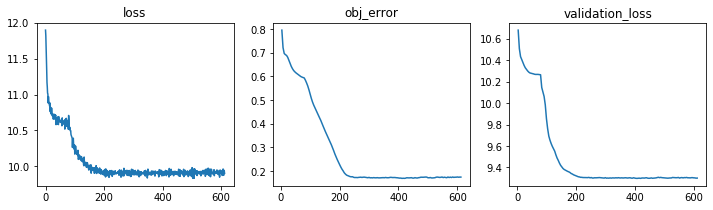

In [22]:
pr_adam.genPlotsRecons()
pr_adam.genPlotMetrics()

In [23]:
with pr_adam.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_adam = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_adam = flops_adam.total_float_ops
    print(flops_adam)
    
graph_def = pr_adam.graph.as_graph_def()
# To calculate the flops required for one adam step,
# I am removing the nodes required for the validation step.
nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_adam.graph, nodes_validation)
print(flops_validation)

total_flops = (flops_adam - flops_validation) * pr_adam.data.index[-1]
print(f'total flops {total_flops:4.3g}')

200174595
22777709
total flops 1.09e+11


## Trying out the L4 

In [24]:
from L4 import L4Adam

W1130 00:10:35.942372 139738636793664 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/examples/tensorflow/far_field_ptychography/L4.py:81: The name tf.train.GradientDescentOptimizer is deprecated. Please use tf.compat.v1.train.GradientDescentOptimizer instead.



In [25]:
pr_adam = AdamPhaseRetriever(ptsim=ptsim, 
                             probe_recons=True,
                             probe_guess_cmplx_2d=probe_guess,
                             validation_ndiffs=50,
                             poisson_loss=True)

In [26]:
with pr_adam.graph.as_default():
    pr_adam._batch_predicted_data = pr_adam._training_predictions_fn(pr_adam._tf_obj, pr_adam._tf_probe)
            
    pr_adam._optparams.training_loss_tensor = pr_adam._training_loss_fn(pr_adam._batch_predicted_data)
            
    pr_adam._optparams.obj_optimizer = L4Adam()
    pr_adam._optparams.obj_minimize_op = pr_adam._optparams.obj_optimizer.minimize(pr_adam._optparams.training_loss_tensor,
                                                        var_list=[pr_adam._tf_obj])
            
    if pr_adam._probe_recons:
        pr_adam._optparams.probe_optimizer = L4Adam()
        pr_adam._optparams.probe_minimize_op = pr_adam._optparams.probe_optimizer.minimize(pr_adam._optparams.training_loss_tensor, 
                                                                var_list=[pr_adam._tf_probe])
pr_adam._optimizers_defined = True

W1130 00:10:48.493490 139738636793664 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/examples/tensorflow/far_field_ptychography/L4.py:125: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.

W1130 00:10:48.567363 139738636793664 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/examples/tensorflow/far_field_ptychography/L4.py:142: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.



In [27]:
pr_adam.initSession()

In [28]:
pr_adam.run(debug_output_epoch_frequency=100, probe_fixed_epochs=20, improvement_threshold=1e-4)
print(pr_adam.data.tail(n=2))

            loss  epoch  obj_error  probe_error  validation_loss  patience
49  32229.773438   49.0   0.875979          NaN      4292.265625      50.0
50  32252.328125   50.0   0.872942          NaN      4306.597168      50.0
